# Synthetic data generation

Generate synthetic data by sampling parameter values from Pareto distributions (for behaviour parameters of political engagement and lead user popularity) and Gaussian distributions (for ideal points).

In [1]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from typing import Union, Optional
from scipy.stats import norm
import jsonlines
import pathlib
import pickle

## Data Generation Functions

In [2]:
def generate_pareto_data(n_samples, n_dimensions, alpha=3):
    """
    Generate multi-dimensional Pareto distributed data.
    
    Parameters:
    - n_samples: Number of data points
    - n_dimensions: Number of dimensions
    - alpha: Shape parameter for Pareto distribution
    """
    return np.random.pareto(alpha, size=(n_samples, n_dimensions))

def generate_normal_data(n_samples, n_dimensions, mu=0, sigma=1):
    """
    Generate multi-dimensional normally distributed data.
    
    Parameters:
    - n_samples: Number of data points
    - n_dimensions: Number of dimensions
    - mu: Mean of the normal distribution
    - sigma: Standard deviation of the normal distribution
    """
    rng = np.random.default_rng()
    if n_dimensions == 1:
        return rng.normal(mu, sigma, n_samples)
    else:
        return rng.multivariate_normal(mu, sigma, size=n_samples)

## Visualisation Functions

In [3]:
def create_distribution_plots(data, title, max_dims=3):
    """
    Create scatter plots for the first 2 or 3 dimensions of the data.
    """
    dims = min(data.shape[1], max_dims)
    
    if dims == 1:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            y=data[:, 0],            
            mode='markers',
            marker=dict(size=5),
            name=title
        ))
        fig.update_layout(
            title=f'{title} Distribution (1D)',            
            yaxis_title='Dimension 1'
        )
    elif dims == 2:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=data[:, 0],
            y=data[:, 1],
            mode='markers',
            marker=dict(size=5),
            name=title
        ))
        fig.update_layout(
            title=f'{title} Distribution (2D)',
            xaxis_title='Dimension 1',
            yaxis_title='Dimension 2'
        )
    else:
        fig = go.Figure(data=[go.Scatter3d(
            x=data[:, 0],
            y=data[:, 1],
            z=data[:, 2],
            mode='markers',
            marker=dict(size=3),
            name=title
        )])
        fig.update_layout(
            title=f'{title} Distribution (3D)',
            scene=dict(
                xaxis_title='Dimension 1',
                yaxis_title='Dimension 2',
                zaxis_title='Dimension 3'
            )
        )
    
    return fig

def create_histogram_matrix(data, title):
    """
    Create a matrix of histograms for each dimension.
    """
    n_dims = data.shape[1]
    fig = make_subplots(rows=n_dims, cols=1, subplot_titles=[f'Dimension {i+1}' for i in range(n_dims)])
    
    for i in range(n_dims):
        fig.add_trace(
            go.Histogram(x=data[:, i], name=f'Dim {i+1}', nbinsx=30),
            row=i+1, col=1
        )
    
    fig.update_layout(
        height=300 * n_dims,
        title_text=f'{title} - Histogram per Dimension',
        showlegend=False
    )
    
    return fig


def plot_array_heatmap(
    array: np.ndarray,
    title: str = "Array Heatmap",
    colorscale: Optional[Union[str, list]] = None,
    show_scale: bool = True,
    x_labels: Optional[list] = None,
    y_labels: Optional[list] = None,
    width: int = 800,
    height: int = 600,
    annotation_format: str = ".2f", xtitle="Columns", ytitle="Rows", show_values=False
):
    """
    Creates a heatmap visualization of a 2D array using plotly.
    Automatically detects binary arrays and uses black/white colorscale.

    Parameters:
    -----------
    array : np.ndarray
        2D array to visualize
    title : str, optional
        Title of the heatmap
    colorscale : str or list, optional
        Custom colorscale. If None, uses 'black/white' for binary arrays
        and 'Viridis' for non-binary arrays
    show_scale : bool, optional
        Whether to show the colorbar
    x_labels : list, optional
        Custom labels for x-axis
    y_labels : list, optional
        Custom labels for y-axis
    width : int, optional
        Width of the figure in pixels
    height : int, optional
        Height of the figure in pixels
    annotation_format : str, optional
        Format string for cell annotations (e.g., ".2f" for 2 decimal places)
    """
    
    # Input validation
    if not isinstance(array, np.ndarray):
        array = np.array(array)
    
    if array.ndim != 2:
        raise ValueError("Input array must be 2-dimensional")

    # Check if array is binary
    is_binary = np.array_equal(array, array.astype(bool))
    
    # Set default colorscale based on array type
    if colorscale is None:
        colorscale = ['white', 'black'] if is_binary else 'Viridis'
    
    # Create axis labels if not provided
    if x_labels is None:
        x_labels = [str(i) for i in range(array.shape[1])]
    if y_labels is None:
        y_labels = [str(i) for i in range(array.shape[0])]
    
    # Format annotations based on binary/continuous values
    if is_binary:
        text = array.astype(int).astype(str)
    else:
        text = np.array([[f"{x:{annotation_format}}" for x in row] for row in array])
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=array,
        x=x_labels,
        y=y_labels,
        colorscale=colorscale,
        showscale=show_scale,
        text=text if show_values else None,
        texttemplate="%{text}",
        textfont={"size": 10},
        hoverongaps=False,
        hovertemplate="x: %{x}<br>y: %{y}<br>value: %{z}<extra></extra>"
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor='center'
        ),
        width=width,
        height=height,
        xaxis=dict(
            title=xtitle,
            side="bottom"
        ),
        yaxis=dict(
            title=ytitle,
            autorange="reversed"  # To match matrix orientation
        ),
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    return fig


def plot_side_by_side_subplots(fig1, fig2, fig3, title="Subplots"):
    """
    Arrange three Plotly figures side by side using subplots.
    
    Parameters:
    fig1, fig2, fig3: Plotly figure objects
    title: Main title for the combined plot
    """
    # Create subplot figure
    if fig2 is not None:
        fig = make_subplots(
            rows=1, 
            cols=3,
            subplot_titles=[fig1.layout.title.text, 
                           fig2.layout.title.text, 
                           fig3.layout.title.text]
        )
    else:
        fig = make_subplots(
            rows=1, 
            cols=2,
            subplot_titles=[fig1.layout.title.text,  
                           fig3.layout.title.text]
        )
        
    
    # Add traces from each figure
    for trace in fig1.data:
        fig.add_trace(trace, row=1, col=1)
    if fig2 is not None:
        for trace in fig2.data:
            fig.add_trace(trace, row=1, col=2)
        for trace in fig3.data:
            fig.add_trace(trace, row=1, col=3)
    else:
        for trace in fig3.data:
            fig.add_trace(trace, row=1, col=2)
        
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            y=0.95,
            font=dict(size=24)
        ),
        showlegend=False,
        height=500,
        width=1200,
        template="plotly_white"
    )
    
    return fig


def create_scatter_plot(data_sets, labels=None, colors=None, sizes=None, symbols=None, title="Interactive Scatter Plot"):
    """
    Create an interactive scatter plot using Plotly for multiple sets of 2D data with customizable appearance.
    
    Parameters:
    data_sets (list): List of tuples, each containing (x_data, y_data) for each dataset
    labels (list): List of strings for legend labels
    colors (list): List of colors for each dataset
    sizes (list): List of marker sizes for each dataset
    symbols (list): List of marker symbols for each dataset
    title (str): Title of the plot
    """
    
    # Set default values if not provided
    n_sets = len(data_sets)
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(n_sets)]
    if colors is None:
        colors = ['blue', 'red', 'green']        
    if sizes is None:
        sizes = [10] * n_sets  # Plotly uses different size scale than matplotlib
    if symbols is None:
        symbols = ['circle', 'square', 'diamond']
    print(labels, colors, symbols, sizes)
    # Create figure
    fig = go.Figure()
    
    # Add each dataset as a separate trace
    for i, ((x_data, y_data), label, color, size, symbol) in enumerate(
            zip(data_sets, labels, colors, sizes, symbols)):
        fig.add_trace(
            go.Scatter(
                x=x_data,
                y=y_data,
                mode='markers',
                name=label,
                marker=dict(
                    size=size,
                    color=color,
                    symbol=symbol,
                    opacity=0.7,
                    line=dict(width=1, color='DarkSlateGrey')
                ),
                hovertemplate=
                f"{label}<br>" +
                "X: %{x:.2f}<br>" +
                "Y: %{y:.2f}<br>" +
                "<extra></extra>"  # This removes the secondary box in the hover tooltip
            )
        )
    
    # Update layout with more customization options
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  # Center the title
            font=dict(size=24)
        ),
        xaxis=dict(
            title="X-axis",
            title_font=dict(size=14),
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='LightGrey'
        ),
        yaxis=dict(
            title="Y-axis",
            title_font=dict(size=14),
            showgrid=True,
            gridwidth=1,
            gridcolor='LightGrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='LightGrey'
        ),
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hovermode='closest',
        plot_bgcolor='white'
    )
    
    
    return fig  # Return the figure object for potential further modifications

## Input parameters - model specifications

In [4]:
# number of leaders
J = 10
# number of followers
K = 1000

mu_e = 0.5
sigma_e = 1

# utility model parameters
gamma = -1
delta = 0
# leaders popularity
alpha_js = generate_pareto_data(n_samples=J, n_dimensions=1, alpha=1)
# followers' political interest
beta_is = generate_pareto_data(n_samples=K, n_dimensions=1, alpha=3)

# dimensionality of ideal points space
dtilde = 2

# leaders' ideal points
mu = lambda x: np.asarray([generate_normal_data(n_samples=1, n_dimensions=1, mu=np.asarray([1.5+x]), sigma=10), generate_normal_data(n_samples=1, n_dimensions=1, mu=np.asarray([-1.5-x]), sigma=5)]).reshape((dtilde,))  #np.zeros((dtilde,))
zs = np.vstack([generate_normal_data(n_samples=1, n_dimensions=dtilde, mu=mu(j), sigma=np.eye(dtilde)) for j in range(J)])

# c(rnorm(K/2-1, 1.50, 1), rnorm(K/2-1, -1.50, 1))

# followers' ideal points - place their mean randomly on the leaders
zidx = np.arange(0, J)
mu_xs = np.vstack(zs[np.random.choice(zidx, size=K, replace=True),:])
xs = np.vstack([generate_normal_data(n_samples=1, n_dimensions=dtilde, mu=mu_xs[i,:], sigma=np.eye(dtilde)) for i in range(K)])

# status quo ideal points
# phis = generate_normal_data(n_samples=J, n_dimensions=dtilde, mu=np.zeros((dtilde,)), sigma=np.eye(dtilde))
mu_phis = np.asarray([generate_normal_data(n_samples=1, n_dimensions=1, mu=np.asarray([-2.5]), sigma=1), generate_normal_data(n_samples=1, n_dimensions=1, mu=np.asarray([3.5]), sigma=1)]).reshape((dtilde,))  #np.zeros((dtilde,))
phis = generate_normal_data(n_samples=J, n_dimensions=dtilde, mu=mu_phis, sigma=np.eye(dtilde))

# utility and distance functions
distance_func = lambda x,y : np.linalg.norm(x-y,ord=2)
utility_func = lambda x : x

### Save parameters

In [5]:
parameters = dict()
parameters["J"] = J
parameters["K"] = K
parameters["mu_e"] = mu_e
parameters["sigma_e"] = sigma_e
parameters["gamma"] = gamma
parameters["delta"] = delta
parameters["alpha"] = alpha_js.flatten().tolist()
parameters["beta"] = beta_is.flatten().tolist()
parameters["d"] = dtilde
parameters["Z"] = zs.reshape((dtilde*J,), order="F").flatten().tolist()
parameters["X"] = xs.reshape((dtilde*K,), order="F").flatten().tolist()
parameters["Phi"] = phis.reshape((dtilde*J,), order="F").flatten().tolist()

DATA_dir = "./data/"
pathlib.Path(DATA_dir).mkdir(parents=True, exist_ok=True)     
with jsonlines.open("{}/synthetic_gen_parameters.jsonl".format(DATA_dir), "a") as f:
    f.write(parameters)

## Compute utilities

In [6]:
utilities_matrix = np.zeros((K, J))
# sigma_noise = 0.5*np.eye(J)
# stochastic_component = generate_normal_data(n_samples=K, n_dimensions=J, mu=np.zeros((J,)), sigma=sigma_noise)

# assuming linear utility in this formulation
for i in range(K):
    for j in range(J):
        utilities_matrix[i,j] = (gamma*distance_func(xs[i, :], zs[j, :]) - delta*distance_func(xs[i, :], phis[j, :]) + alpha_js[j] + beta_is[i])[0] + generate_normal_data(n_samples=1, n_dimensions=1, mu=0, sigma=0.5)
        # print(xs[i, :], zs[j, :], phis[j, :], alpha_js[j] + beta_is[i]) + generate_normal_data(n_samples=1, n_dimensions=1, mu=0, sigma=0.5)
        # print(distance_func(xs[i, :], zs[j, :]))
       
# utilities_matrix += stochastic_component
utilities_mat_probab = norm.cdf(utilities_matrix, loc=mu_e, scale=sigma_e)

/tmp/ipykernel_54263/4193396343.py:8: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



## Plot

In [7]:
fig = plot_array_heatmap(
        utilities_matrix,
        title="Computed utilities",
        colorscale="Viridis",
        xtitle="Leaders", ytitle="Followers", show_values=False, show_scale=False
    )
# fig.show()
# noisefig = plot_array_heatmap(
#         stochastic_component,
#         title="Error component",
#         colorscale="Viridis",
#         show_values=False, show_scale=False
#     )
# noisefig.show()
follow_matrix = utilities_mat_probab > 0.5
followfig = plot_array_heatmap(
        follow_matrix.astype(np.int8),
        title="Following",
        xtitle="Leaders", ytitle="Followers", show_values=False, show_scale=False
    )


# followfig.show()
allplots = plot_side_by_side_subplots(fig, None, followfig, title="Synthetic data")
allplots.show()

### Save observed data

In [8]:
with open("./data/Y.pickle", "wb") as f:
    pickle.dump(follow_matrix, f, protocol=4)

parameter_space_dim = (K+2*J)*dtilde + J + K + 4
# for distributing per N rows
N = round(parameter_space_dim/J)
print(N)
# subset rows (users)
subset_dataset_size = N
for i in range(0, K, N):
    with open("./data/dataset_{}_{}.pickle".format(i,i+N), "wb") as f:
        pickle.dump(follow_matrix[i:i+N, :], f, protocol=4)    

305


['Followers', 'Leaders'] ['blue', 'orange'] ['circle', 'diamond'] [8, 12]


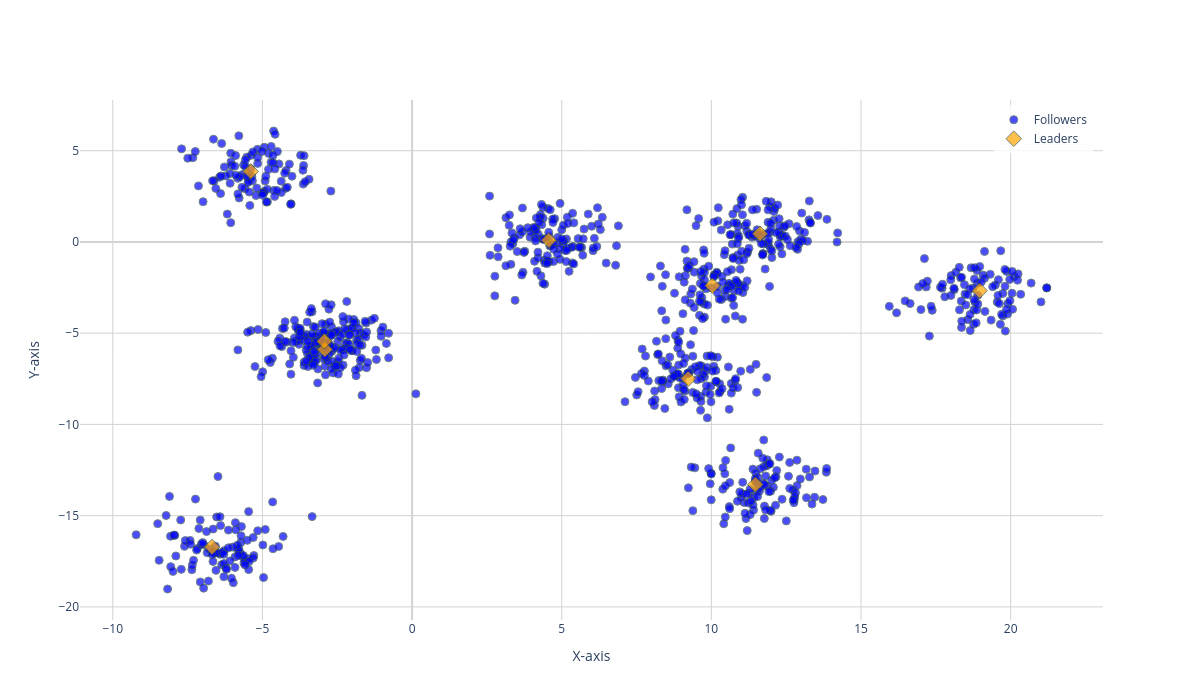

In [9]:
if delta > 0:
    fig = create_scatter_plot(
            data_sets=[(xs[:, 0], xs[:, 1]), (zs[:, 0], zs[:, 1]), (phis[:, 0], phis[:, 1])],
            labels=["Followers", "Leaders", "Status quo"],
            colors=["blue", "orange", "green"],
            sizes=[8, 12, 10],
            symbols=["circle", "diamond", "star"],
            title=""
        )
else:
    fig = create_scatter_plot(
            data_sets=[(xs[:, 0], xs[:, 1]), (zs[:, 0], zs[:, 1])],
            labels=["Followers", "Leaders"],
            colors=["blue", "orange"],
            sizes=[8, 12],
            symbols=["circle", "diamond"],
            title=""
        )
fig.layout.height = 700
fig.show()